In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from jupyterthemes import jtplot
from sklearn.metrics import auc, roc_curve, roc_auc_score
%matplotlib inline
jtplot.style()

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
#Находим категориальные признаки
cat_feature = list(df.dtypes[df.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
df[cat_feature] = df[cat_feature].fillna('nan')

#отфильтруем непрерывные признаки
num_feature = [f for f in df if f not in (cat_feature + ['Id', 'SalePrice'])]

In [4]:
# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = df[cat_feature].nunique()
print(cat_nunique)

MSZoning          5
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        5
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          5
BsmtCond          5
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         5
CentralAir        2
Electrical        6
KitchenQual       4
Functional        7
FireplaceQu       6
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
PoolQC            4
Fence             5
MiscFeature       5
SaleType          9
SaleCondition     6
dtype: int64


In [5]:
# Создаем дамми-переменные для категорий
dummy = pd.get_dummies(df[cat_feature], columns=cat_feature)

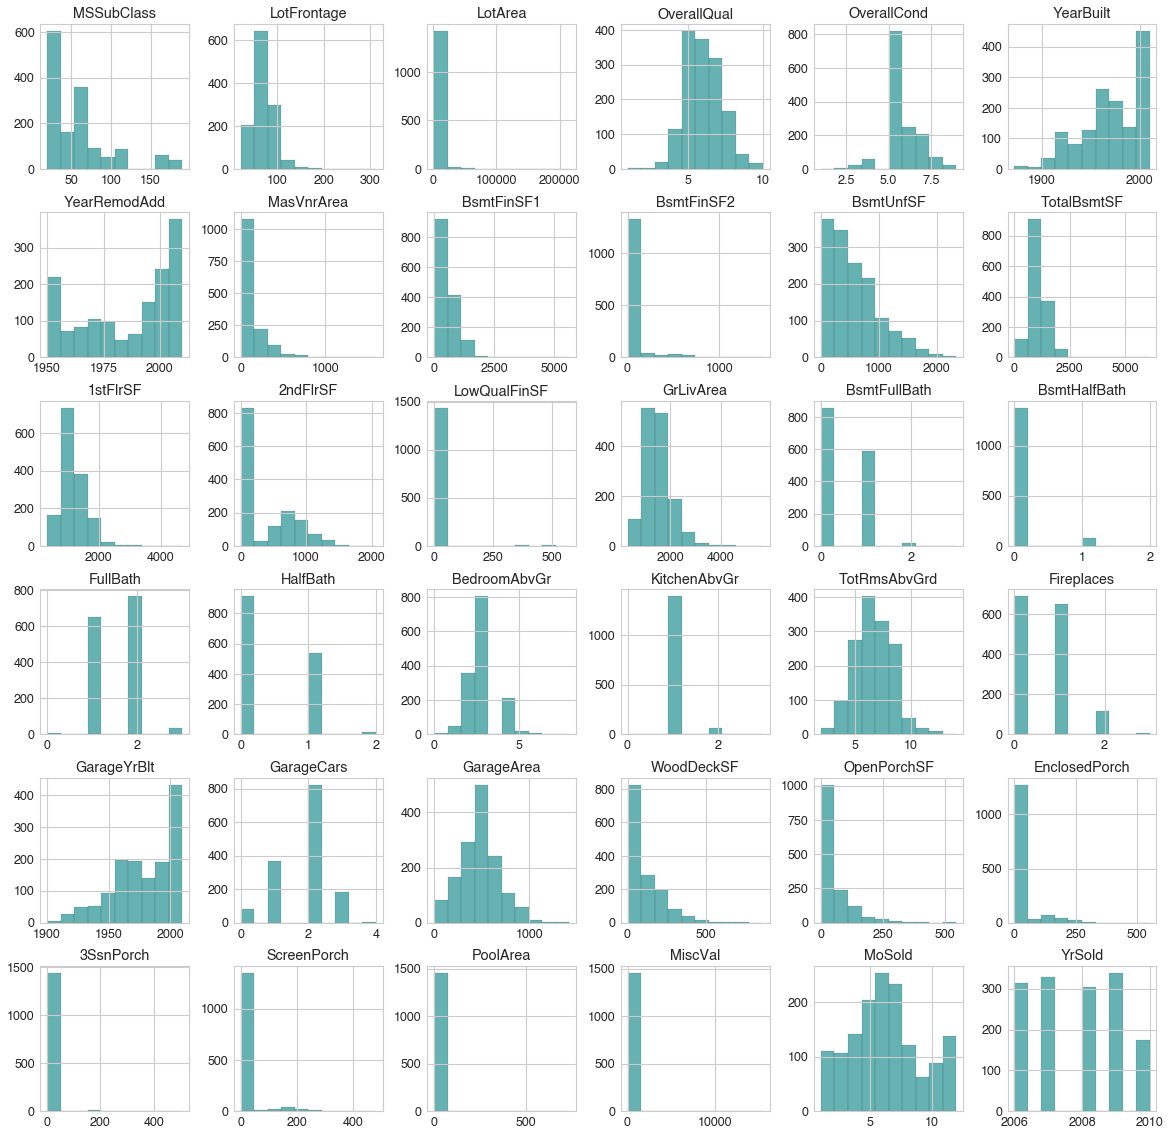

In [6]:
# Визуализируем количественные признаки
df[num_feature].hist(edgecolor = 'black', alpha = .6, figsize = (20, 20), color='teal');

In [7]:
# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
df_ = pd.concat([df[num_feature].fillna(-999),
                     dummy], axis=1)

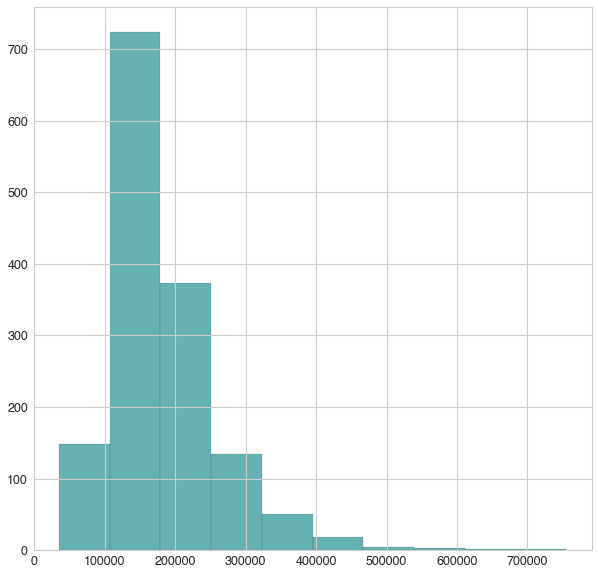

In [8]:
# Цена
df['SalePrice'].hist(edgecolor = 'black', alpha = .6, figsize = (10, 10), color='teal');

In [25]:
# DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

DTR = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, max_features=0.5)

Х_feature = df_
Y_feature = df['SalePrice']


# Выполним стандартизацию признаков
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

# Обучем наши признаки
sc.fit(Х_feature)

# Тренировочные значения 
Х_feature_std = sc.transform(Х_feature)

# Обучим для отбора признаков
DTR.fit(Х_feature_std, Y_feature)

DecisionTreeRegressor(max_depth=5, max_features=0.5, min_samples_leaf=10)

### Отбор признаков

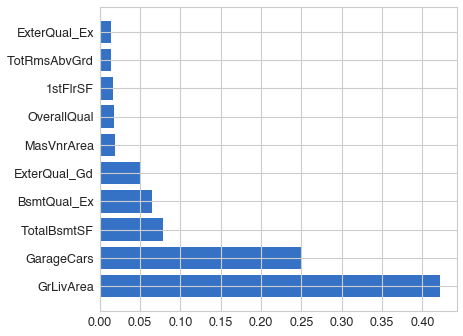

In [26]:
imp = pd.Series(DTR.feature_importances_)
imp = imp.sort_values(ascending=False)

imp = imp[:10]
    
plt.barh(np.arange(len(imp)), imp.values)
plt.yticks(np.arange(len(imp.index.values)), df_.iloc[:, imp.index.values].columns);

In [27]:
# Для дальнейшего обучения возьмем 5 отобранных признаков
feature_col = df_.iloc[:, imp[:5].index.values].columns

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_[feature_col], df['SalePrice'], test_size=0.3, random_state=0)

# Стандартизация
sc.fit(X_train)

Х_train_std = sc.transform(X_train)

X_test_std = sc.transform(X_test)

In [29]:
from sklearn.svm import LinearSVR

svm = LinearSVR(epsilon = 0.0 , tol = 0.1 , C = 0.8 , loss = 'squared_epsilon_insensitive',
                intercept_scaling = 0.3 , random_state = 0, max_iter = 1000)

In [30]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors = 5)

In [31]:
from sklearn.linear_model import ElasticNet

Elastic = ElasticNet(alpha=0.7, l1_ratio=0.8, fit_intercept=True, precompute=False, max_iter=1000, 
           tol=0.0001, warm_start=False, positive=False, random_state=0, selection='cyclic')

In [32]:
DTR = DecisionTreeRegressor(max_depth=3, min_samples_leaf=10, max_features=0.5)

In [33]:
from sklearn.ensemble import StackingRegressor
Stack = StackingRegressor(
    [
        ('Elastic', Elastic),
        ('DTR', DTR),
        ('svm', svm),
        ('neigh', neigh)
    ], Elastic)

In [34]:
Stack.fit(Х_train_std, y_train);

In [35]:
Stack.final_estimator_

ElasticNet(alpha=0.7, l1_ratio=0.8, random_state=0)

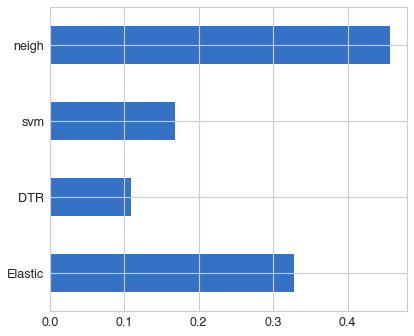

In [36]:
pd.Series(Stack.final_estimator_.coef_.flatten(), index=Stack.named_estimators_.keys()).plot(kind='barh');

In [37]:
Stack.score(X_test_std, y_test).round(5) 

0.73399

In [38]:
Stack.score(Х_train_std, y_train).round(5) 

0.82717